# Project 3 - Data Munging - Clustering Guardian Headlines

Jeremy Lane, Juan Carlos Ceballos, Ya Ting Huang

In [1]:
# Load the packages
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import PorterStemmer
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.cluster import Birch, SpectralClustering, MeanShift
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jdola\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jdola\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# This is how we initially collected the data, through the Guaridan API. We had a 200-page limit per day.
# Each day, we collected 200 more pages into CSVs, which are read below.

# # Make the API request
# api_key = '17f242ac-b7c7-4658-a91b-09103883911f'  # Use your actual API key
# url = f"https://content.guardianapis.com/search?api-key={api_key}&page-size=200"
# response = requests.get(url)
# data = response.json()

In [3]:
# # Extract data and load into DataFrame
# articles = data['response']['results']
# df = pd.DataFrame(articles)
# df.to_csv('guardian_headlines_pages_401_to_600.csv')

In [4]:
# Load the data
df1 = pd.read_csv('guardian_headlines.csv')
df2 = pd.read_csv('guardian_headlines_pages_201_to_400.csv')
df3 = pd.read_csv('guardian_headlines_pages_401_to_600.csv')
df4 = pd.read_csv('guardian_headlines_pages_601_to_800.csv')
df5 = pd.read_csv('guardian_headlines_pages_801_to_1000.csv')
df = pd.concat([df1,df2,df3,df4,df5],ignore_index=True)
df = df.drop(columns=['Unnamed: 0'],inplace=False)
df = df.drop_duplicates()
df = df.dropna()
df.head()

id      type  \
0  australia-news/live/2024/mar/14/australia-news...  liveblog   
1  football/2024/mar/14/socceroos-adam-taggart-aj...   article   
2  society/2024/mar/13/uk-cancer-study-big-fall-i...   article   
3  australia-news/2024/mar/14/miner-killed-in-und...   article   
4  football/live/2024/mar/13/atletico-madrid-v-in...  liveblog   

        sectionId     sectionName    webPublicationDate  \
0  australia-news  Australia news  2024-03-13T23:53:49Z   
1        football        Football  2024-03-13T23:46:27Z   
2         society         Society  2024-03-13T23:30:03Z   
3  australia-news  Australia news  2024-03-13T23:26:34Z   
4        football        Football  2024-03-13T23:18:07Z   

                                            webTitle  \
0  Australia news live: Giles condemns Coalition’...   
1  Socceroos recall Adam Taggart and Ajdin Hrusti...   
2  UK cancer study shows big fall in death rates ...   
3  Ballarat goldmine collapse: miner killed in un...   
4  Atlético Madrid v Inter: Champions League last...   

                                              webUrl  \
0  https://www.theguardian.com/australia-news/liv...   
1  https://www.theguardian.com/football/2024/mar/...   
2  https://www.theguardian.com/society/2024/mar/1...   
3  https://www.theguardian.com/australia-news/202...   
4  https://www.theguardian.com/football/live/2024...   

                                              apiUrl  isHosted      pillarId  \
0  https://content.guardianapis.com/australia-new...     False   pillar/news   
1  https://content.guardianapis.com/football/2024...     False  pillar/sport   
2  https://content.guardianapis.com/society/2024/...     False   pillar/news   
3  https://content.guardianapis.com/australia-new...     False   pillar/news   
4  https://content.guardianapis.com/football/live...     False  pillar/sport   

  pillarName  
0       News  
1      Sport  
2       News  
3       News  
4      Sport

## Text Processing

In [5]:
# This is the first step in our text processing
# Define the stemmer
stemmer = PorterStemmer()

In [6]:
def text_processing(text):
    """
    Function for processing inputted text
    """
    # Turn all the words to lower case and split the string to its individual words
    words = text.lower().split()
    # Get rid of non alphabetic elements, like punctuations and digits
    lower_words = [''.join([i for i in word if i.isalpha()]) for word in words]
    # Get rid of stop words
    clean_words = [word for word in lower_words if word not in stopwords.words('english')]
    # Apply stemming to each word
    stemmed_words = [stemmer.stem(word) for word in clean_words]
    # Join the clean words back into a string
    clean_text = ' '.join(clean_words)
    return clean_text

In [7]:
# I added a column to the df with the cleaned and stemmed words so that we can use it
# later in the notedbook
df['webTitle_stemmed'] = df.webTitle.apply(text_processing)

In [8]:
df.webTitle_stemmed

0       australia news live giles condemns coalitions ...
1       socceroos recall adam taggart ajdin hrustic wo...
2       uk cancer study shows big fall death rates sin...
3       ballarat goldmine collapse miner killed underg...
4       atlético madrid v inter champions league last ...
                              ...                        
2667    cant make eat teachers parents share school me...
2668     sports quiz week six nations fa cup cheltenham f
2669                             tell us affected closure
2670    ohio republican candidates exintern says adult...
2671    one thing weve learned kate photo scandal ther...
Name: webTitle_stemmed, Length: 2672, dtype: object

## TFIDF

In [9]:
# We tried TFIDF before as a first step, before trying pre-trained embeddings
tf = TfidfVectorizer()

In [10]:
X = df.webTitle_stemmed
X = tf.fit_transform(X)
X

<2672x8343 sparse matrix of type '<class 'numpy.float64'>'
	with 24206 stored elements in Compressed Sparse Row format>

## K-Means Clustering

In [11]:
df.sectionName.value_counts()

sectionName
World news            357
Australia news        322
Opinion               312
US news               235
Politics              216
Football              128
UK news               122
Sport                 113
Business              101
Environment            96
Society                74
Life and style         59
Television & radio     59
Books                  55
Music                  44
Film                   42
Media                  40
Technology             38
Education              35
Global development     31
Stage                  30
Culture                25
Art and design         24
Food                   22
Science                21
Money                  17
Fashion                12
Law                    11
News                    8
Games                   6
Travel                  5
From the Observer       4
Crosswords              4
Inequality              2
Cities                  1
Wellness                1
Name: count, dtype: int64

In [12]:
df.pillarName.value_counts()

pillarName
News         1714
Opinion       312
Arts          285
Sport         241
Lifestyle     120
Name: count, dtype: int64

In [13]:
# We chose 5 clusters because there are 5 pillar names in the data.
# There were too many sections names to try to map them to clusters.
k=5
kmeans = KMeans(n_clusters=k, random_state=42,n_init='auto')
clustered_headlines = kmeans.fit(X)

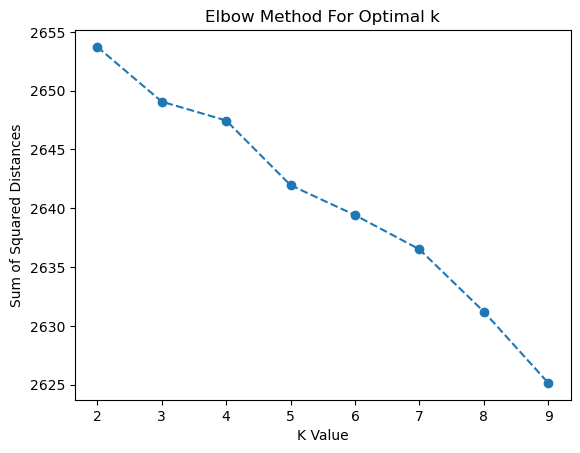

In [14]:
# Elbow method shows no clear elbow, which doesn't help us to choose a number of clusters
ssd = []

for k in range(2,10):
    model = KMeans(n_clusters=k,n_init='auto',random_state=42)
    model.fit(X)
    #Sum of squared distances of samples to their closest cluster center.
    ssd.append(model.inertia_)
    
plt.plot(range(2,10),ssd,'o--')
plt.xlabel("K Value")
plt.ylabel("Sum of Squared Distances")
plt.title('Elbow Method For Optimal k')
plt.show()

In [15]:
# The silhouette score shows that K-Means isn't a great algorithm for our data.
K = range(2,30)
silhouette = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42,n_init='auto').fit(X)
    labels = kmeans.predict(X)
    silhouette.append(silhouette_score(X, labels))

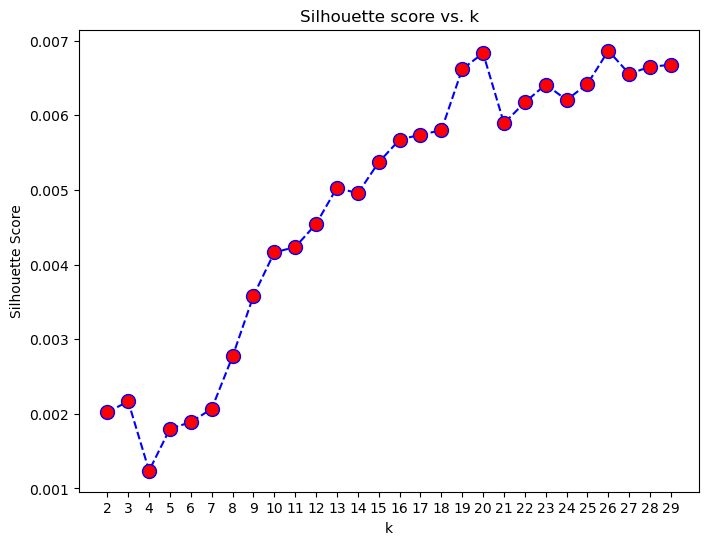

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(K, silhouette, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
#plotting the both K range and then the actual distances 
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette score vs. k')
plt.xticks(K);

The accuracy score is: 0.0782185628742515 



<Axes: >

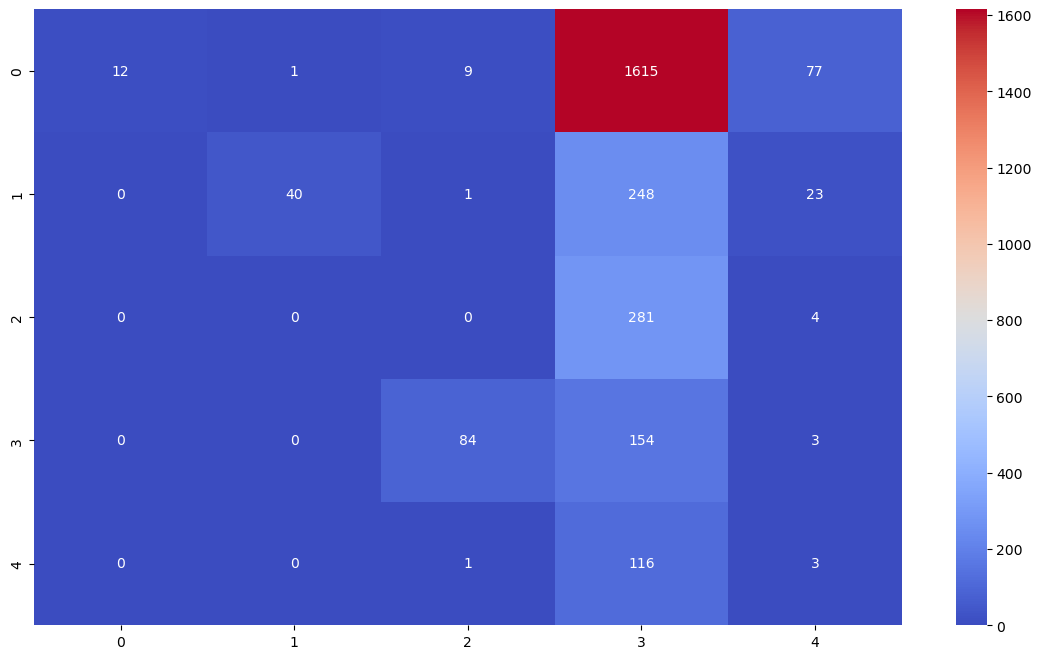

In [17]:
# We mapped the pillarNames to numerical values to be able to create a confusion matrix
# and a classification report

value_map = {'News':0,'Opinion':1,'Arts':2,'Sport':3,'Lifestyle':4}
df['pillarName'].replace(value_map,inplace=True)

k=5
kmeans = KMeans(n_clusters=k, n_init='auto',random_state=42)
kmeans.fit(X)
labels = kmeans.predict(X)

y = df['pillarName']

print(f'The accuracy score is: {accuracy_score(y,labels)} \n')
plt.figure(figsize=(14,8))
sns.heatmap(confusion_matrix(y, labels), annot=True, cmap='coolwarm',fmt='d')

# The accuracy score, confusion matrix and classification report show that the pillarNames
# are not well represented in the clusters.

In [18]:
print(classification_report(df['pillarName'],kmeans.labels_))

              precision    recall  f1-score   support

           0       1.00      0.01      0.01      1714
           1       0.98      0.13      0.23       312
           2       0.00      0.00      0.00       285
           3       0.06      0.64      0.12       241
           4       0.03      0.03      0.03       120

    accuracy                           0.08      2672
   macro avg       0.41      0.16      0.08      2672
weighted avg       0.76      0.08      0.05      2672



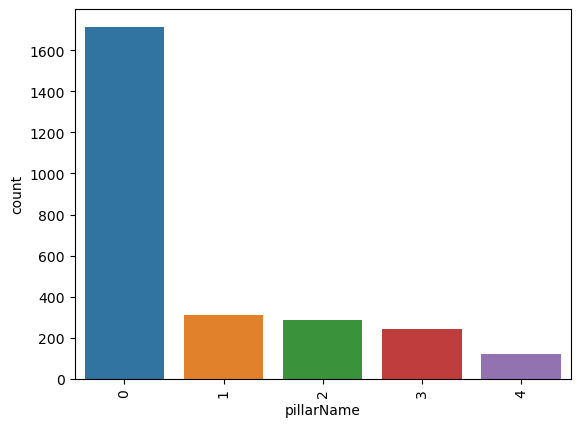

In [19]:
# This demonstrates that the data has imbalanced pillar names, with 0 being 'news'
sns.countplot(data=df,x='pillarName')
plt.xticks(rotation=90);

## t-SNE

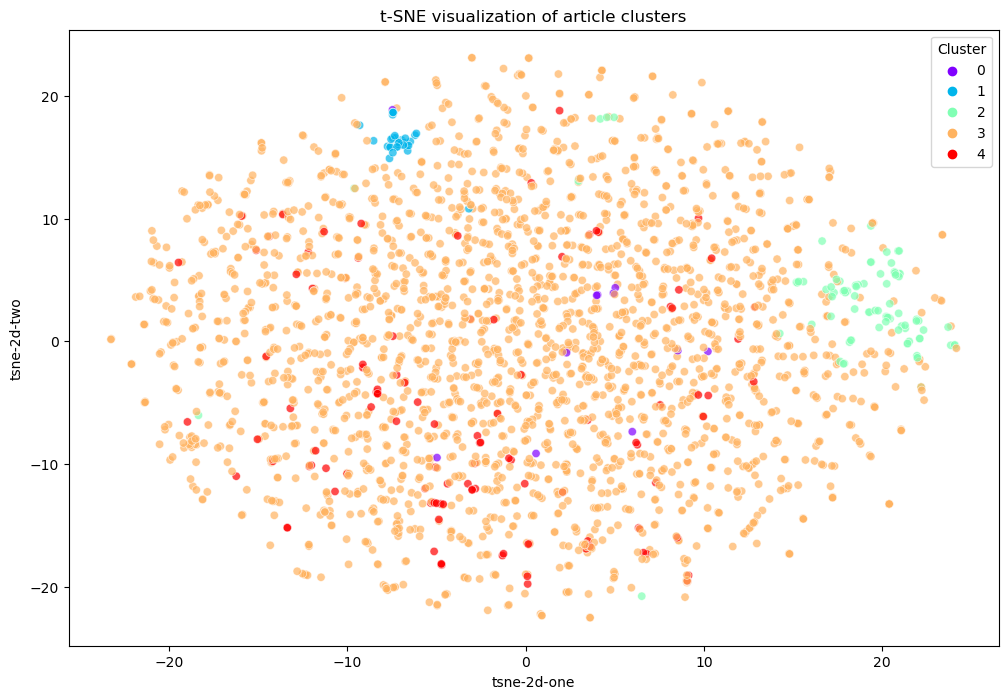

In [20]:
df['cluster'] = clustered_headlines.labels_

# Apply t-SNE to reduce dimensions
tsne = TSNE(n_components=2, perplexity=40, n_iter=300, random_state=42, init='random')
X_tsne = tsne.fit_transform(X)

# Store the first and second dimensions in the df
df['tsne-2d-one'] = X_tsne[:, 0]
df['tsne-2d-two'] = X_tsne[:, 1]

# Plot the dimensions
plt.figure(figsize=(12, 8))
sns.scatterplot(x='tsne-2d-one', y='tsne-2d-two', hue='cluster', palette='rainbow', data=df, alpha=0.7, legend='full')

plt.title('t-SNE visualization of article clusters')
plt.legend(title='Cluster')
plt.show()

In [21]:
# We also visualized the data with 'hue' as 'pillarName' to see if there are any similarities
# between the clustered data and the pillar names.

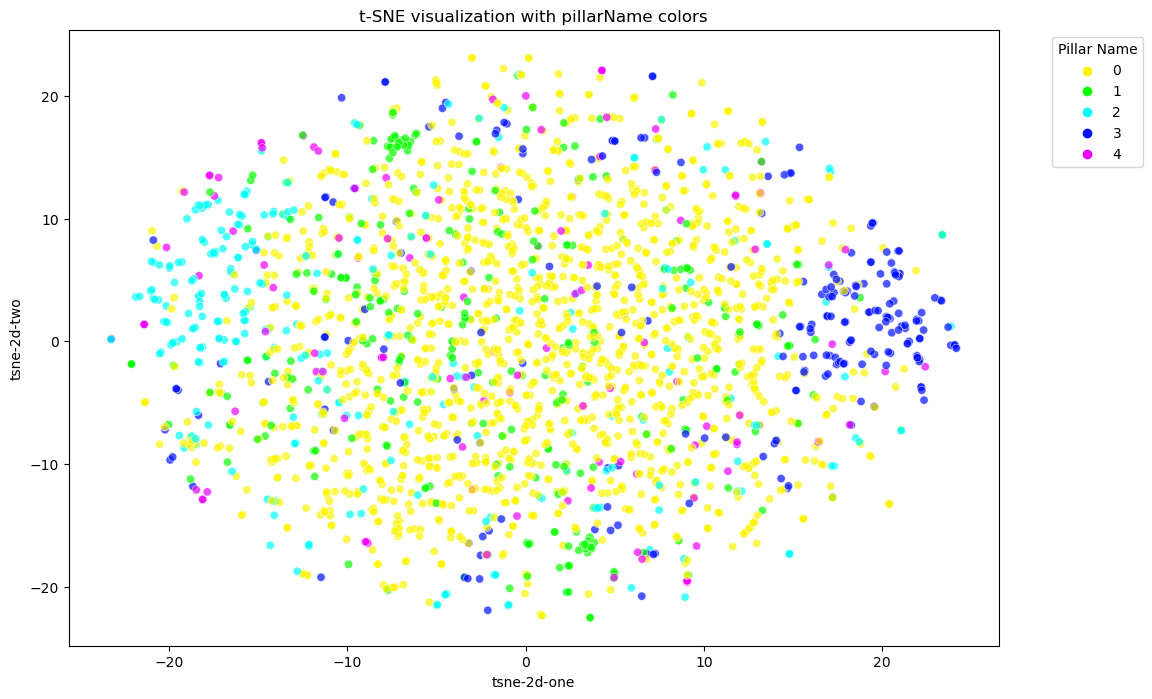

In [22]:
plt.figure(figsize=(12, 8))
# 'Hue' is set to 'pillarName' for color encoding based on that variable
sns.scatterplot(x='tsne-2d-one', y='tsne-2d-two', hue='pillarName', palette=sns.color_palette("hsv", len(df['pillarName'].unique())), data=df, alpha=0.7)

plt.title('t-SNE visualization with pillarName colors')
plt.legend(title='Pillar Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# value_map = {'News':0,'Opinion':1,'Arts':2,'Sport':3,'Lifestyle':4}

In [23]:
# We got the top terms out of each cluster to see if there are any cluster themes.
# We found that K-Means found one main cluster - Sports - as well as one small Opinion cluster.
# K-Means also appears to have missed an Arts cluster.

print("Top terms per cluster:")
order_centroids = clustered_headlines.cluster_centers_.argsort()[:, ::-1]
terms = tf.get_feature_names_out()
for i in range(k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Top terms per cluster:
Cluster 0:
 secretary
 environment
 shell
 theresa
 emissions
 says
 biotechnology
 department
 may
 dropping
Cluster 1:
 view
 editorial
 guardian
 observer
 bad
 better
 politics
 must
 tory
 time
Cluster 2:
 cup
 football
 league
 world
 weekend
 daily
 fa
 manchester
 happened
 champions
Cluster 3:
 says
 uk
 review
 new
 happened
 labour
 debate
 war
 letters
 trump
Cluster 4:
 us
 tiktok
 supreme
 trump
 ban
 house
 court
 john
 government
 tell


## Testing different clustering algorithms with t-SNE

In [24]:
# After we saw that K-Means wasn't finding many clusters, 
# we set out to try other algorithms that might work.

# Initializing TSNE
tsne = TSNE(n_components = 2, random_state = 42, init="random")
# #Fitting and transforming features to reduce dimensional space 
tsne_features = tsne.fit_transform(X)

## Birch

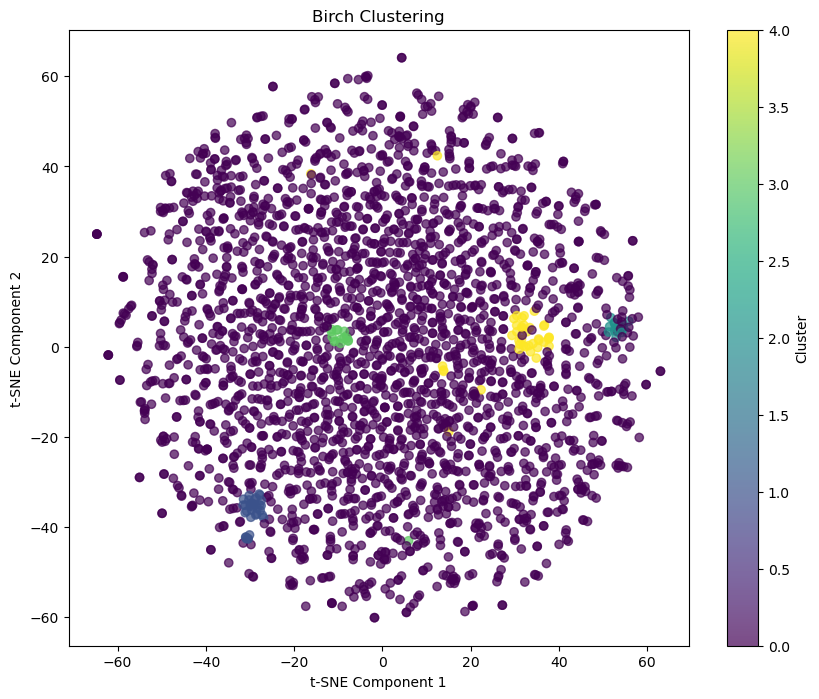

In [25]:
# Visualizing clusters for Birch algorithm

birch = Birch(n_clusters=5) # 5 clusters again for comparative reasons 
birch_headlines = birch.fit(X) # Fitting alforithm with tsne features
cluster_labels_birch = birch.labels_

plt.figure(figsize=(10, 8))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=cluster_labels_birch, cmap='viridis', alpha=0.7)
plt.title('Birch Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

### Affinity Propogation

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


<Figure size 1400x1000 with 0 Axes>

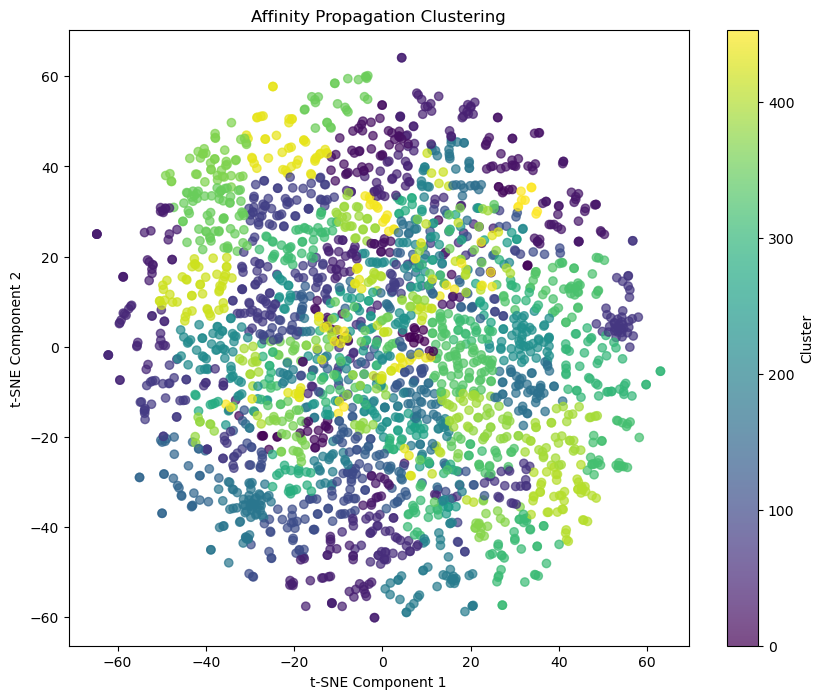

In [26]:
# Initializing Affinity Propagation
affinity_propagation = AffinityPropagation()

# Fitting Affinity Propagation to the t-SNE features
cluster_labels_affinity = affinity_propagation.fit_predict(tsne_features)

# Plot the clusters
plt.figure(figsize=(14, 10))

plt.figure(figsize=(10, 8))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=cluster_labels_affinity, cmap='viridis', alpha=0.7)
plt.title('Affinity Propagation Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

## Ward

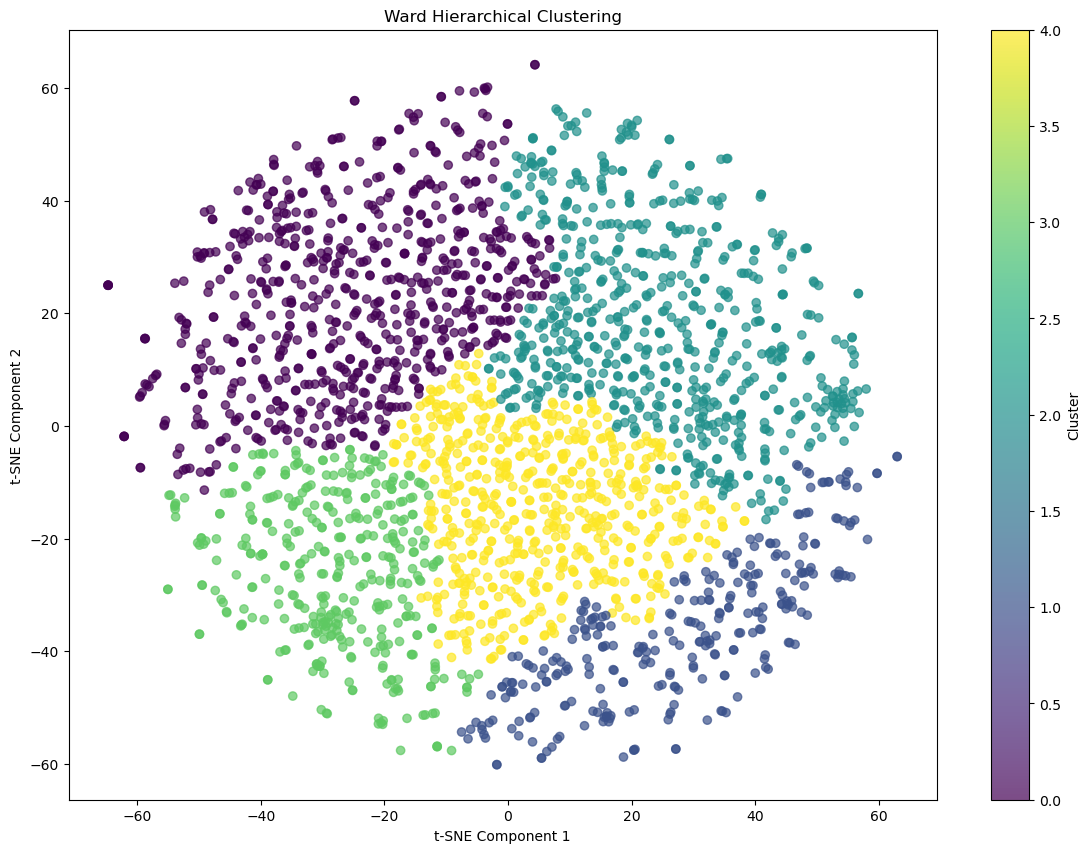

In [27]:
# Initializing Ward hierarchical clustering with 5 clusters
ward_clustering = AgglomerativeClustering(n_clusters=5, linkage='ward')

# Fitting the model to the data
cluster_labels_ward = ward_clustering.fit_predict(tsne_features)

# Visualize the clusters
plt.figure(figsize=(14, 10))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=cluster_labels_ward, cmap='viridis', alpha=0.7)
plt.title('Ward Hierarchical Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

## Pre-Trained Embeddings

In [28]:
# We wanted to see if pre-trained embeddings would provide better results than TFIDF

import sys
import gensim
import gensim.downloader as model_api
import re

In [29]:
word_vectors = model_api.load("glove-wiki-gigaword-50")

In [30]:
words = df.webTitle_stemmed.str.split()
words = pd.DataFrame(words.tolist())

In [31]:
def soft_get(w):
    try:
        return word_vectors[w] #either get the word or return 0s
    except KeyError:
        return np.zeros(word_vectors.vector_size)
    
def map_vectors(row):
    try:
        res=row.loc[row.notna()].apply(soft_get)
        if len(res) >=1:
            return np.sum(res)
        else:
            return np.zeros(word_vectors.vector_size)
            # take the row and take the columns that are not NaN and get the soft_get and then take the sum of that
    except:
        return np.zeros(word_vectors.vector_size)

In [32]:
emb = pd.DataFrame(words.apply(map_vectors, axis=1).tolist())
emb

0         1         2         3         4         5         6   \
0     1.114127 -1.320544 -1.646728  2.230834  0.189293  0.449314 -1.214480   
1    -1.610388  1.384818 -1.356810  3.939326  0.540745  1.351968 -3.890554   
2     2.455055  3.027270  0.754094 -4.097210 -1.133600  4.523195 -6.845870   
3     0.082558  0.438937  2.235440  0.963492 -1.633920  2.417821 -2.157865   
4     0.652720  4.209054 -3.705911  6.303469 -0.896344 -3.209950 -3.023710   
...        ...       ...       ...       ...       ...       ...       ...   
2667  0.435474  1.026682 -2.608666 -7.044616  5.021192 -0.197382 -5.705560   
2668 -4.142780  5.424734 -3.116156  4.906193 -1.820463 -2.098660 -2.371986   
2669  1.948830 -0.125090  1.682510 -0.615867 -0.237760 -0.895600 -0.523118   
2670 -1.057564  1.239111  3.148547 -1.085745  1.348750  2.322430 -7.139820   
2671  2.368492  4.122957 -3.614750 -1.453749  3.683578  4.954054 -5.503081   

            7         8         9   ...        40        41        42  \
0     1.723477  3.292287 -1.698150  ... -2.520791  1.270875  3.884090   
1     1.328949  0.714138 -2.438500  ...  0.489770 -0.211010 -0.306896   
2    -2.082626  2.347980  2.209210  ... -6.657210 -0.710512 -0.773593   
3     4.681540  1.789631 -1.787101  ... -2.400930 -2.551997  1.426860   
4     5.647635 -5.751541  0.593296  ...  1.647282 -3.215233 -1.114858   
...        ...       ...       ...  ...       ...       ...       ...   
2667 -0.002117 -0.597190  0.699190  ... -2.027322 -0.907961  0.687372   
2668  0.513580 -0.330190 -3.400690  ...  1.036080 -2.217190  0.377694   
2669  1.268980  0.455422 -0.837480  ... -1.817913  0.088444  2.691810   
2670 -0.996580  0.038930 -3.294502  ... -0.814582  1.674925 -4.045180   
2671  2.165941 -1.070940  1.414530  ... -0.398970  1.108024 -0.437719   

            43        44        45        46        47        48        49  
0     0.773139  1.554485  3.385695 -5.180189  1.566130  2.060461  1.027810  
1    -3.004380  1.240951  4.840250  0.377215  1.776930 -1.232932 -1.980602  
2     0.293180  2.478694  0.566592  0.820860 -1.787571 -0.679811  1.563026  
3    -2.324490  1.455088 -1.473969 -3.387676 -3.434602  1.940760 -6.868310  
4    -3.337660 -2.382097  4.226290  0.698261 -0.658924  5.010931 -6.052989  
...        ...       ...       ...       ...       ...       ...       ...  
2667  5.907370  3.807482  3.320392 -0.872703  0.326071  0.012494  2.803710  
2668 -0.154340 -0.573623  5.291550 -0.813025  3.616688  1.027361 -1.470809  
2669  0.016414  0.820430  0.790013 -1.755188  1.770809 -1.072575  1.534360  
2670  2.402633 -0.022230  0.658150 -2.365460  0.356871 -0.142410  4.352911  
2671  0.145270  0.460277 -2.292039  1.354373 -1.837262  0.250460  3.431271  

[2672 rows x 50 columns]

In [33]:
k=5
kmeans = KMeans(n_clusters=k, random_state=42,n_init='auto')
clustered_headlines = kmeans.fit(emb)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2672 samples in 0.002s...
[t-SNE] Computed neighbors for 2672 samples in 1.410s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2672
[t-SNE] Computed conditional probabilities for sample 2000 / 2672
[t-SNE] Computed conditional probabilities for sample 2672 / 2672
[t-SNE] Mean sigma: 5.076968
[t-SNE] KL divergence after 50 iterations with early exaggeration: 75.836205
[t-SNE] KL divergence after 300 iterations: 2.327355


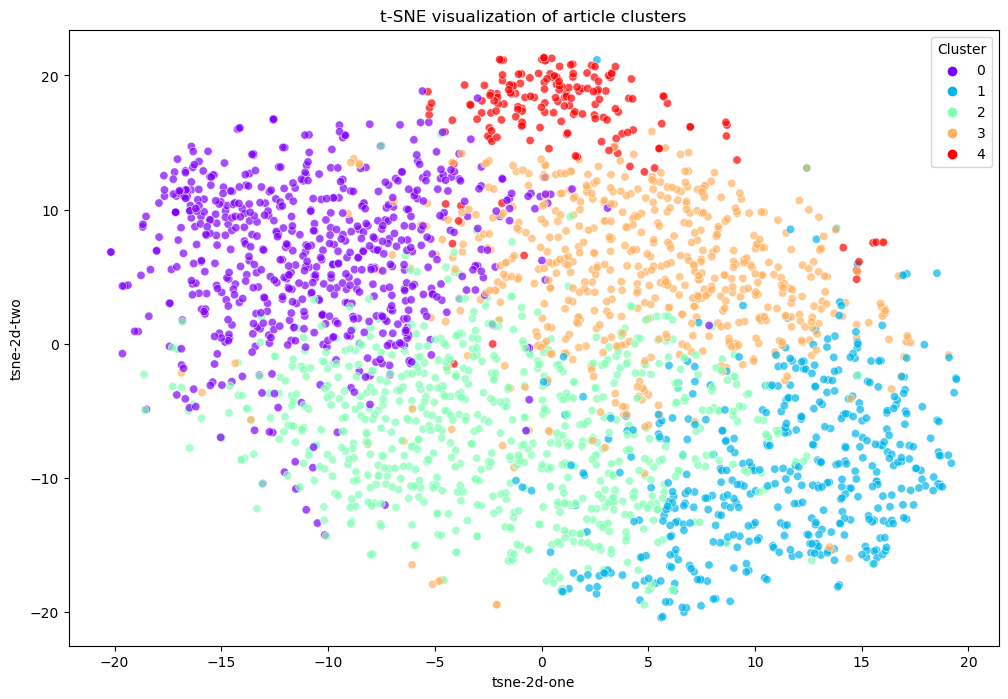

In [44]:
# Apply t-SNE to reduce dimensions with the "random" initialization to handle sparse input
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=42, init='random')
emb_tsne = tsne.fit_transform(emb)

# Create a new DataFrame
df_tsne = pd.DataFrame(data = emb_tsne, columns = ['tsne-2d-one', 'tsne-2d-two'])
df_tsne['cluster'] = clustered_headlines.labels_

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='tsne-2d-one', 
    y='tsne-2d-two', 
    hue='cluster', 
    palette='rainbow', 
    data=df_tsne, 
    alpha=0.7, 
    legend='full'
)

plt.title('t-SNE visualization of article clusters')
plt.legend(title='Cluster')
plt.savefig('t-sne_embeddings.png', dpi=150)
plt.show()

In [35]:
df['tsne-2d-one'] = emb_tsne[:,0]
df['tsne-2d-two'] = emb_tsne[:,1]

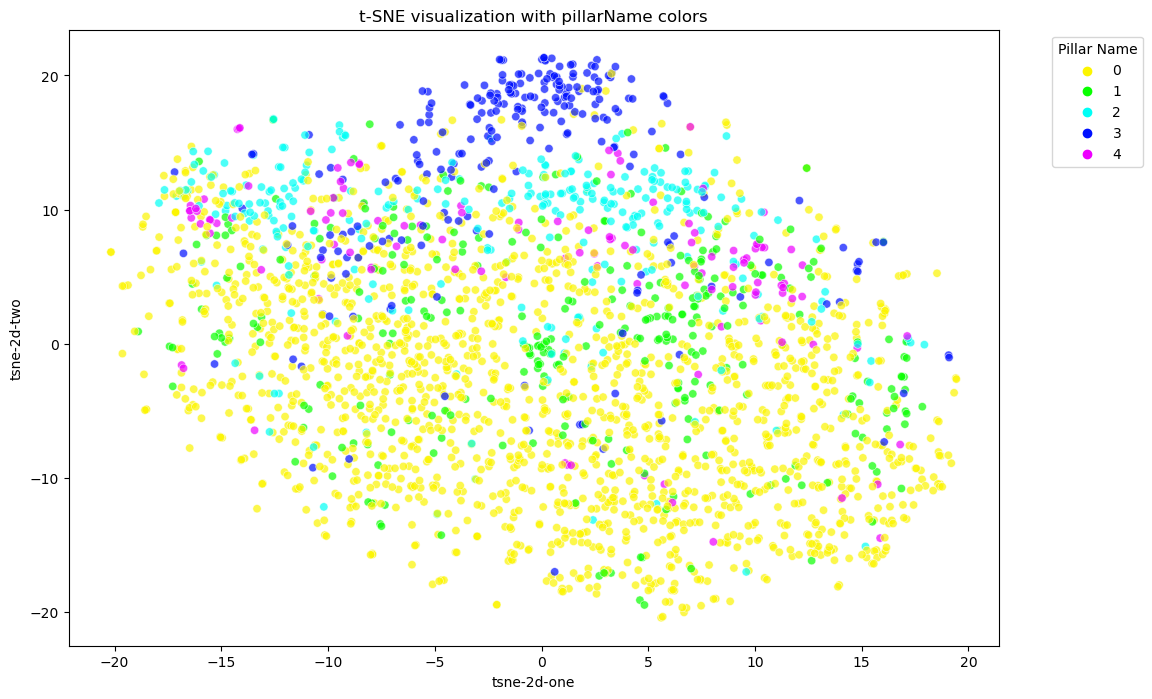

In [36]:
# value_map = {'News':0,'Opinion':1,'Arts':2,'Sport':3,'Lifestyle':4}
plt.figure(figsize=(12, 8))
# Use Seaborn's scatterplot
# This time, 'hue' parameter is set to 'sectionName' for color encoding based on that variable
sns.scatterplot(x='tsne-2d-one', y='tsne-2d-two', hue='pillarName', palette=sns.color_palette("hsv", len(df['pillarName'].unique())), data=df, alpha=0.7)

plt.title('t-SNE visualization with pillarName colors')
plt.legend(title='Pillar Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# value_map = {'News':0,'Opinion':1,'Arts':2,'Sport':3,'Lifestyle':4}

In [37]:
# We don't know why we're getting the same words for all clusters.

print("Top terms per cluster:")
order_centroids = clustered_headlines.cluster_centers_.argsort()[:, ::-1]
terms = tf.get_feature_names_out()
for i in range(k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Top terms per cluster:
Cluster 0:
 acceleration
 abortions
 absolutely
 absurdity
 abbey
 able
 abroad
 accept
 abayas
 accuse
Cluster 1:
 acceleration
 abortions
 accuser
 absolute
 accept
 accounts
 academy
 abraham
 aaron
 abroad
Cluster 2:
 acceleration
 abortions
 accuser
 academy
 abbey
 accept
 abroad
 absolute
 absolutely
 accuse
Cluster 3:
 acceleration
 abortions
 absolutely
 absurdity
 abuses
 abayas
 accept
 abandon
 accusations
 abbey
Cluster 4:
 acceleration
 accept
 abortions
 accuse
 abandon
 abroad
 abbotts
 accidental
 absurd
 abandons


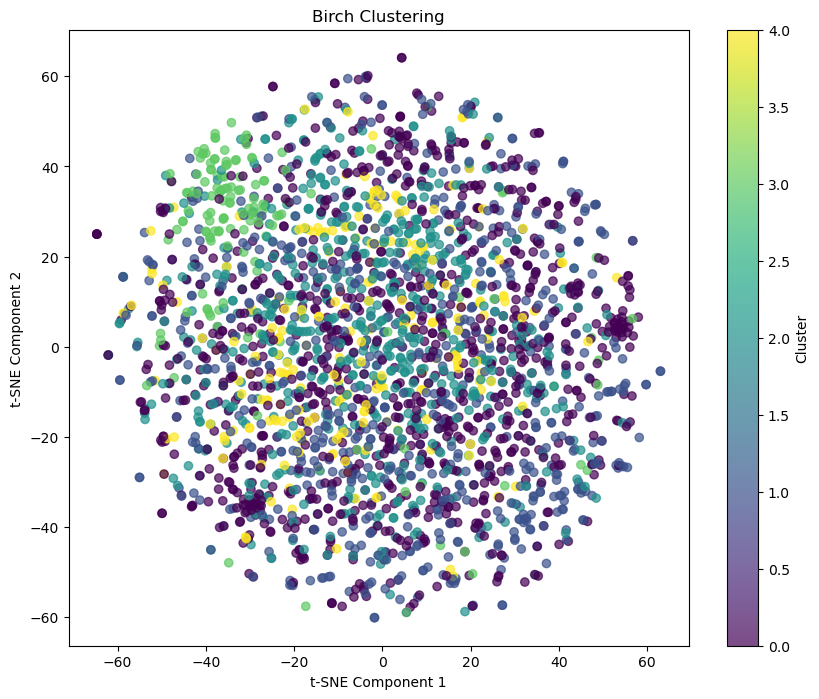

In [38]:
# Visualizing clusters for Birch algorithm

birch = Birch(n_clusters=5) # 5 clusters again for comparative reasons 
birch_headlines = birch.fit(emb) # Fitting alforithm with tsne features
cluster_labels_birch = birch.labels_

plt.figure(figsize=(10, 8))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=cluster_labels_birch, cmap='viridis', alpha=0.7)
plt.title('Birch Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

<Figure size 1400x1000 with 0 Axes>

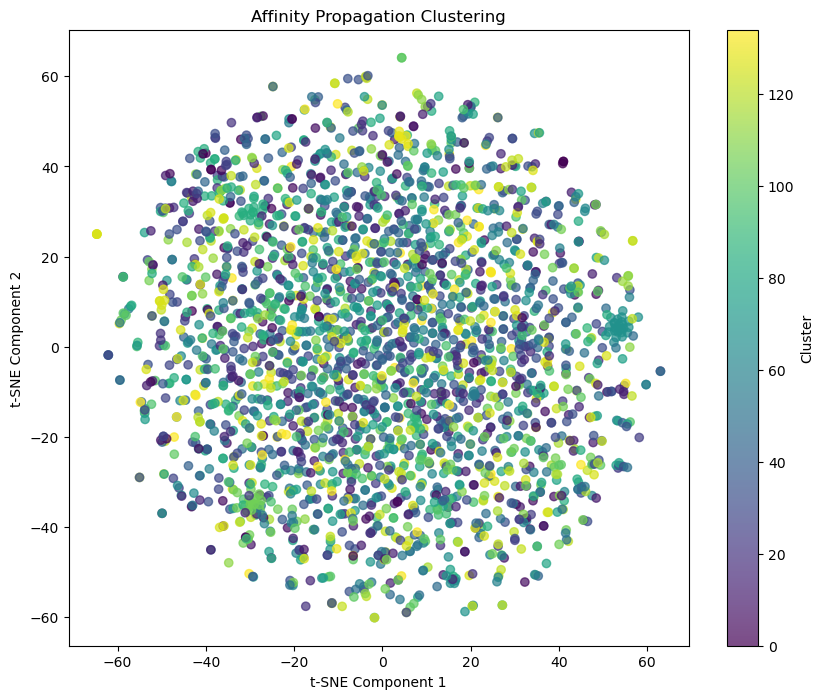

In [39]:
# Initializing Affinity Propagation
affinity_propagation = AffinityPropagation()

# Fitting Affinity Propagation to the t-SNE features
cluster_labels_affinity = affinity_propagation.fit_predict(emb)

# Plot the clusters
plt.figure(figsize=(14, 10))

plt.figure(figsize=(10, 8))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=cluster_labels_affinity, cmap='viridis', alpha=0.7)
plt.title('Affinity Propagation Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

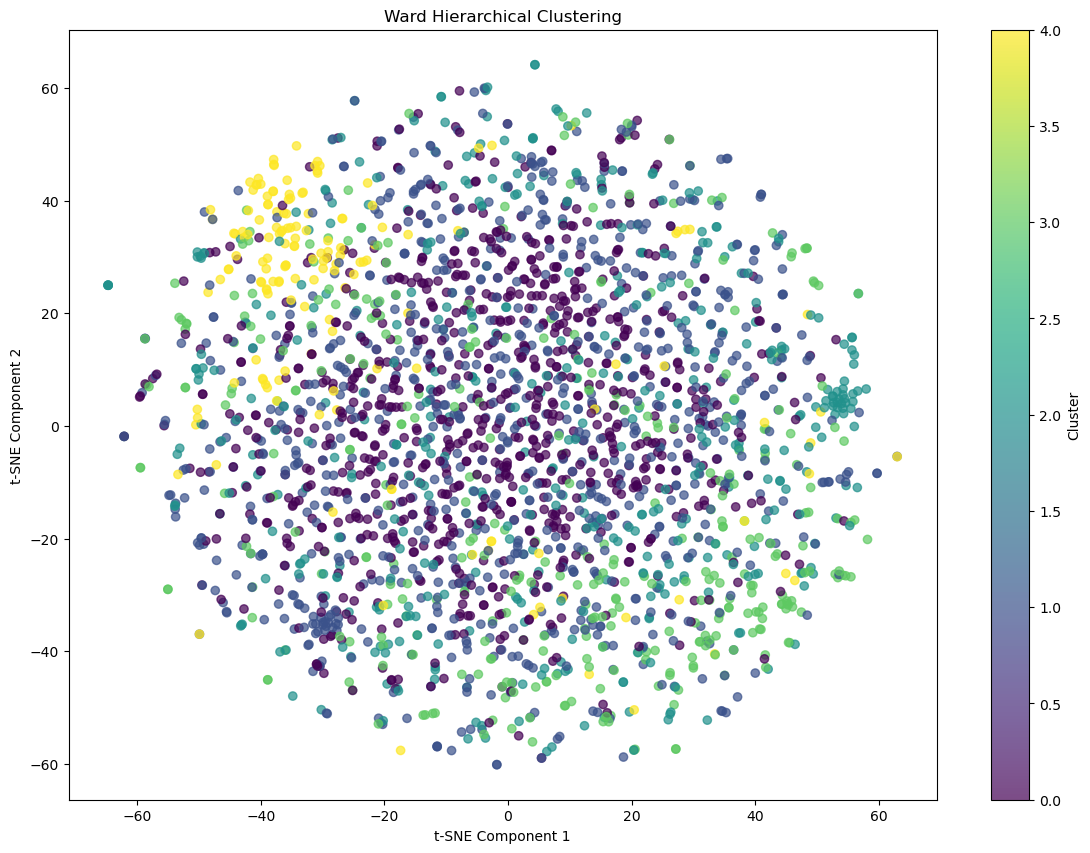

In [40]:
# Initializing Ward hierarchical clustering with 5 clusters
ward_clustering = AgglomerativeClustering(n_clusters=5, linkage='ward')

# Fitting the model to the data
cluster_labels_ward = ward_clustering.fit_predict(emb)

# Visualize the clusters
plt.figure(figsize=(14, 10))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=cluster_labels_ward, cmap='viridis', alpha=0.7)
plt.title('Ward Hierarchical Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

## Interpretations

Different combinations of preprocessing techniques, dimensionality reduction, and clustering algorithms were tested to improve data clustering. After stemming the news headlines, TF-IDF was applied to convert the text data into numerical features. Both PCA and t-SNE were used for dimensionality reduction, with t-SNE showing superior performance in capturing underlying structures.

Evaluation of 11 clustering algorithms, including K-means, affinity propagation, mean shift, spectral clustering, ward, agglomerative clustering, DBSCAN, HDBSCAN, OPTICS, BIRCH, and Gaussian Mixture, was conducted. K-means, Birch, and Ward performed relatively better in grouping similar data points, while DBSCAN, HDBSCAN, OPTICS, and Gaussian Mixture exhibited less effectiveness in capturing data structure. For the purposes of the length of the notebook, only the clustering algorithms that appeared to form potentially meaningful clusters are included: K-Mean, Birch, Affinity Propogation, and Ward.

Unfortunately we are dealing with imbalanced data in this scenario. This occurs when there are unequal observations for different classes in a classification dataset. Such imbalances are common in real-world scenarios, where the minority class often holds greater significance, necessitating techniques to enhance its detection rate. This imbalance presents a significant challenge for predictive modeling, as algorithms favor the more prevalent class.

The reason why KMeans does not work is due to the imbalanced classes. When we look at the pillarName column in the data, the News category had dramatically more values. The metrics indicated in the classificated report and confusion matrix further emphasized this (accuracy score was 8%.)

To conclude, only two small clusters were found by K-means, when the headlines had been processed by TFIDF Vectorizer: Sport and, arguably, opinion. K-Means failed to find a clear Arts cluster, which we can see on the visualization of pillarNames. When using pre-trained embeddings to process the headlines, K-Means appears to have found the Sport cluster as well; however, this wasn't validated by the getting the top words out (there must be a logical error that's causing the top words for all clusters to be the same). Birch, Affinity Propogation, and Ward show potential; however, after using t-SNE as a dimensionality reduction technique before clustering, we were unable to get the top words out of their clusters. To find a better clustering algorithm, we would likely have to scrape full articles from the Guardian, rather than just the headlines, which don't appear to provide enough natural language data for our algorithms to find meaningful clusters.